In [1]:
#! pip install -r ../requirements.txt
%load_ext autoreload
%autoreload 2

from dataclasses import asdict
from pathlib import Path
import pickle
import json
from pprint import pprint
import re
import sys


BASE = Path('.').resolve().parent
if BASE not in sys.path:
    sys.path.append(str(BASE))

from dotenv import load_dotenv
import jieba
import openai
import pandas as pd
from nltk.corpus import stopwords
import seaborn as sns

from scrape.letterboxd import get_many_letterboxd_reviews
from scrape.prompts import FINANCE_SUMMARY_PROMPT, MOVIE_SUMMARY_PROMPT
from scrape.absa import aspects
from scrape.absa.absa import count_absa, create_absa_counts_df, create_absa_df, get_absa, get_val_from_absa_output_key, get_annotated_absa
from scrape.absa.prompts import GET_ABSA_MOVIE_PROMPT, GET_ABSA_FINANCE_PROMPT
from scrape.analysis import (
    create_wordcloud,
    create_word_count,
    get_summary, 
    )
from scrape.types import LetterboxdReview, OpenAIModel
from scrape.ptt import get_ptt_post
from scrape.types import PTTPost

load_dotenv()

client = openai.AsyncOpenAI()
jieba.set_dictionary(BASE / "data" / "dict.txt.big")

letterboxd_reviews_path = BASE / "examples" / "the-boy-and-the-heron-letterboxd-240-reviews.json"
letterboxd_absa_path = BASE / "examples" / "the-boy-and-the-heron-letterboxd-240-absa.json"
letterboxd_summary_path = BASE / "examples" / "the-boy-and-the-heron-letterboxd-240-summary.txt"

ptt_path = BASE / "examples" / "ptt.json"
ptt_summary_path = BASE / "examples" / "ptt-summary.txt"
ptt_absa_path = BASE / "examples" / "ptt-absa.json"

# 電影

## 先抓好多個評論

`get_many_letterboxd_reviews` 是基於 `get_letterboxd_review` 的函數，可以抓取多個電影的評論。

In [2]:
base_url = (
    "https://letterboxd.com/film/the-boy-and-the-heron/reviews/by/activity/page/{page}/"
)
reviews = get_many_letterboxd_reviews(base_url, 1, 1)

Page:   0%|          | 0/1 [00:00<?, ?it/s]

2023-12-09 10:03:22.299 | INFO     | scrape.letterboxd:get_many_letterboxd_reviews:80 - Got 12 reviews


## 做面向情感分析（Aspect Based Sentiment Analysis, ABSA）

`get_absa` 會叫模型去抓評論中的 aspect，並且給出該 aspect 的情緒。

In [3]:
absa = get_absa(
    client=client, 
    texts=[r.review for r in reviews],
    base_prompt=GET_ABSA_MOVIE_PROMPT,
    model_name=OpenAIModel.GPT3_5)
pprint(absa)

2023-12-09 10:03:25.877 | INFO     | scrape.absa.absa:get_absa:43 - Chunked into 1 chunks


  0%|          | 0/1 [00:00<?, ?it/s]

[('text_1',
  {'Cultural Representation': 'neutral',
   'Emotional Impact': 'positive',
   'Humor': 'neutral',
   'Overall': 'positive',
   'contains_spoilers': False}),
 ('text_2',
  {'Characters': 'positive',
   'Emotional Impact': 'positive',
   'Ending/Resolution': 'negative',
   'Originality': 'positive',
   'Overall': 'positive',
   'Plot': 'positive',
   'contains_spoilers': True}),
 ('text_3',
  {'Ending/Resolution': 'positive',
   'Overall': 'positive',
   'Plot': 'positive',
   'contains_spoilers': False}),
 ('text_4',
  {'Emotional Impact': 'positive',
   'Overall': 'positive',
   'contains_spoilers': False}),
 ('text_5',
  {'Emotional Impact': 'positive',
   'Originality': 'positive',
   'Overall': 'positive',
   'contains_spoilers': False}),
 ('text_6',
  {'Characters': 'positive',
   'Overall': 'positive',
   'contains_spoilers': False}),
 ('text_7',
  {'Emotional Impact': 'positive',
   'Overall': 'positive',
   'contains_spoilers': False}),
 ('text_8',
  {'Cinematograph

## 生成摘要

In [16]:
summary = get_summary(client, [str(r) for r in reviews], base_prompt=MOVIE_SUMMARY_PROMPT, model_name=OpenAIModel.GPT3_5)
pprint(summary)

('### Summary\n'
 'The collection of reviews above provides a detailed and multifaceted view of '
 'Hayao Miyazaki\'s potentially final film, now known as "The Boy and the '
 'Heron." Renowned for his meticulous animation and storytelling, Miyazaki '
 'seems to have created another memorable piece that resonates deeply with '
 'audiences. While not unanimously his best work, the film clearly holds '
 "significant emotional weight and showcases Miyazaki's undeniable skill and "
 "passion for his craft. Many reviews highlight the film's complex themes, "
 'rich emotional tapestry, and the striking visuals characteristic of Studio '
 "Ghibli's legacy. Despite some concerns about narrative focus and abrupt "
 "pacing, the movie's introspective nature and potential as a culmination of "
 "Miyazaki's career make it a must-see for fans and cinephiles alike.\n"
 '\n'
 '### Watch this if...\n'
 "You are a fan of Hayao Miyazaki or Studio Ghibli's work, appreciating "
 'intricate animation and st

## 各種儲存

做測試和實驗的時候，先把資料儲存起來，以免每次都要重新抓資料。

`x` 檔案開啟模式只允許創新的檔案，如果檔案已經存在，就會出現錯誤。如果要覆蓋檔案，可以使用 `w` 模式。

In [ ]:
with letterboxd_absa_path.open("x") as f:
    json.dump(absa, f, ensure_ascii=False, indent=4)
with letterboxd_reviews_path.open("x") as f:
    json.dump([asdict(r) for r in reviews], f, ensure_ascii=False, indent=4)
with letterboxd_summary_path.open("x") as f:
    print(summary, file=f)

## 載入資料

In [5]:
with letterboxd_reviews_path.open() as f:
    reviews: list[LetterboxdReview] = [LetterboxdReview(**d) for d in json.load(f)]

with letterboxd_absa_path.open() as f:
    absa: list[tuple[str, dict[str, str]]] = json.load(f)

with letterboxd_summary_path.open() as f:
    summary = f.read()

## 建立 reviews DataFrame 並增加資料

In [6]:
reviews_df = pd.DataFrame([asdict(r) for r in reviews])
reviews_df

,username,date,rating,review
0,davidehrlich,07 Sep 2023,9.0,How does someone follow one of the greatest an...
1,David Sims,07 Sep 2023,10.0,spent some of the movie worried it was gonna b...
2,CinemaJoe,19 Oct 2023,10.0,The helplessness you feel when you realize the...
3,˗ˏˋ suspirliam ˊˎ˗,29 Jul 2023,10.0,watched in tokyo on imax i am truly living my ...
4,the film drunk,08 Sep 2023,7.0,I once again leave a Miyazaki film thinking ab...
...,...,...,...,...
235,Misja Oostdijk,29 Oct 2023,9.0,9.3LIFF #3 - The Boy and the HeronHayao Miyaza...
236,nora,24 Oct 2023,7.0,a beautifully rendered parable. potentially th...
237,張硯拓,09 Oct 2023,10.0,朋友問我為什麼喜歡《蒼鷺與少年》，我說，因為我不覺得看懂是最重要的事。上面那句話，想必有些人...
238,FinnyBinny,08 Oct 2023,9.0,THE BOY AND THE HERON REVIEW:|| UK PREMIERE @ ...


### 先加評論是否暴雷

`get_absa_dict_val` 會從 `absa` 的物件中取出要的鍵的值

因為模型有時候會漏掉評論，所以我們必須在 `get_absa_dict_val` 中確認評論的順序

跑完之後可以發現長度不對 

In [7]:
contains_spoilers = get_val_from_absa_output_key(absa, "contains_spoilers")
print(len(contains_spoilers))
contains_spoilers

239


{0: True,
 1: True,
 2: True,
 3: True,
 4: True,
 5: False,
 6: True,
 7: False,
 8: False,
 9: False,
 10: True,
 11: False,
 12: False,
 13: False,
 14: False,
 15: False,
 16: True,
 17: False,
 18: False,
 19: False,
 20: False,
 21: False,
 22: True,
 23: True,
 25: False,
 26: False,
 27: True,
 28: False,
 29: False,
 30: False,
 31: False,
 32: True,
 33: False,
 34: False,
 35: True,
 36: False,
 37: False,
 38: False,
 39: False,
 40: False,
 41: False,
 42: False,
 43: False,
 44: False,
 45: False,
 46: False,
 47: False,
 48: False,
 49: False,
 50: False,
 51: False,
 52: True,
 53: True,
 54: False,
 55: False,
 56: True,
 57: False,
 58: True,
 59: False,
 60: True,
 61: True,
 62: False,
 63: False,
 64: True,
 65: False,
 66: False,
 67: False,
 68: True,
 69: False,
 70: False,
 71: False,
 72: False,
 73: True,
 74: True,
 75: True,
 76: False,
 77: True,
 78: False,
 79: False,
 80: False,
 81: False,
 82: False,
 83: True,
 84: False,
 85: False,
 86: False,
 87:

In [8]:
reviews_df["contains_spoilers"] = contains_spoilers
reviews_df

,username,date,rating,review,contains_spoilers
0,davidehrlich,07 Sep 2023,9.0,How does someone follow one of the greatest an...,True
1,David Sims,07 Sep 2023,10.0,spent some of the movie worried it was gonna b...,True
2,CinemaJoe,19 Oct 2023,10.0,The helplessness you feel when you realize the...,True
3,˗ˏˋ suspirliam ˊˎ˗,29 Jul 2023,10.0,watched in tokyo on imax i am truly living my ...,True
4,the film drunk,08 Sep 2023,7.0,I once again leave a Miyazaki film thinking ab...,True
...,...,...,...,...,...
235,Misja Oostdijk,29 Oct 2023,9.0,9.3LIFF #3 - The Boy and the HeronHayao Miyaza...,False
236,nora,24 Oct 2023,7.0,a beautifully rendered parable. potentially th...,False
237,張硯拓,09 Oct 2023,10.0,朋友問我為什麼喜歡《蒼鷺與少年》，我說，因為我不覺得看懂是最重要的事。上面那句話，想必有些人...,False
238,FinnyBinny,08 Oct 2023,9.0,THE BOY AND THE HERON REVIEW:|| UK PREMIERE @ ...,True


有一個沒有ABSA的資料

In [9]:
reviews_df.query("contains_spoilers.isnull()")

,username,date,rating,review,contains_spoilers
24,Julia🦕,15 Oct 2023,9.0,Rewatched just for warawara,NaN


## ABSA 加到 reviews DataFrame

`create_absa_df` 會把每個評論的面向依照情感被分到不同的列

In [10]:
absa_df = create_absa_df(absa)
absa_df

,positive,negative,neutral
user_idx,,,
0,"overall, plot, characters, emotional impact, v...",,
1,"overall, emotional impact, plot, characters",,
2,"overall, emotional impact, ending/resolution",,
3,"overall, visual effects, emotional impact, plot",,
4,"overall, characters, emotional impact",,
...,...,...,...
235,"plot, characters, cinematography, soundtrack m...",pacing,
236,"plot, characters, visual effects, overall",,
237,"plot, characters, soundtrack music, overall",,emotional impact


In [11]:
reviews_df = pd.merge(reviews_df, absa_df, left_index=True, right_index=True, how="outer")
reviews_df

,username,date,rating,review,contains_spoilers,positive,negative,neutral
0,davidehrlich,07 Sep 2023,9.0,How does someone follow one of the greatest an...,True,"overall, plot, characters, emotional impact, v...",,
1,David Sims,07 Sep 2023,10.0,spent some of the movie worried it was gonna b...,True,"overall, emotional impact, plot, characters",,
2,CinemaJoe,19 Oct 2023,10.0,The helplessness you feel when you realize the...,True,"overall, emotional impact, ending/resolution",,
3,˗ˏˋ suspirliam ˊˎ˗,29 Jul 2023,10.0,watched in tokyo on imax i am truly living my ...,True,"overall, visual effects, emotional impact, plot",,
4,the film drunk,08 Sep 2023,7.0,I once again leave a Miyazaki film thinking ab...,True,"overall, characters, emotional impact",,
...,...,...,...,...,...,...,...,...
235,Misja Oostdijk,29 Oct 2023,9.0,9.3LIFF #3 - The Boy and the HeronHayao Miyaza...,False,"plot, characters, cinematography, soundtrack m...",pacing,
236,nora,24 Oct 2023,7.0,a beautifully rendered parable. potentially th...,False,"plot, characters, visual effects, overall",,
237,張硯拓,09 Oct 2023,10.0,朋友問我為什麼喜歡《蒼鷺與少年》，我說，因為我不覺得看懂是最重要的事。上面那句話，想必有些人...,False,"plot, characters, soundtrack music, overall",,emotional impact
238,FinnyBinny,08 Oct 2023,9.0,THE BOY AND THE HERON REVIEW:|| UK PREMIERE @ ...,True,"plot, characters, soundtrack music, visual eff...",pacing,


## 算ABSA各個面向的情感分數

接下來我們要做一個 熱圖 （Heatmap），來看看各個面向的情感分布

In [12]:
absa

[['text_1',
  {'overall': 'positive',
   'contains_spoilers': True,
   'Plot': 'positive',
   'Characters': 'positive',
   'Emotional Impact': 'positive',
   'Visual Effects': 'positive',
   'Direction': 'positive'}],
 ['text_2',
  {'overall': 'positive',
   'contains_spoilers': True,
   'Emotional Impact': 'positive',
   'Plot': 'positive',
   'Characters': 'positive'}],
 ['text_3',
  {'overall': 'positive',
   'contains_spoilers': True,
   'Emotional Impact': 'positive',
   'Ending/Resolution': 'positive'}],
 ['text_4',
  {'overall': 'positive',
   'contains_spoilers': True,
   'Visual Effects': 'positive',
   'Emotional Impact': 'positive',
   'Plot': 'positive'}],
 ['text_5',
  {'overall': 'positive',
   'contains_spoilers': True,
   'Characters': 'positive',
   'Emotional Impact': 'positive'}],
 ['text_6',
  {'overall': 'positive',
   'contains_spoilers': False,
   'Emotional Impact': 'positive',
   'Cultural Representation': 'positive'}],
 ['text_7',
  {'overall': 'positive',
   

`count_absa` 會計算每個評論的面向加情感的頻率

In [13]:
absa_counts = count_absa(absa)
print(absa_counts.positive.most_common(10))
print(absa_counts.negative.most_common(10))
print(absa_counts.neutral.most_common(10))

[('overall', 180), ('emotional impact', 138), ('plot', 79), ('cinematography', 60), ('originality', 51), ('characters', 34), ('direction', 32), ('soundtrack/music', 31), ('visual effects', 28), ('ending/resolution', 13)]
[('plot', 21), ('overall', 19), ('pacing', 9), ('humor', 4), ('emotional impact', 4), ('originality', 3), ('direction', 3), ('genre suitability', 2), ('acting', 2), ('personal enjoyment', 2)]
[('overall', 40), ('plot', 19), ('dialogue', 9), ('pacing', 8), ('emotional impact', 8), ('originality', 5), ('genre suitability', 3), ('characters', 3), ('humor', 2), ('soundtrack/music', 1)]


In [14]:
absa_counts_df = create_absa_counts_df(absa_counts)
absa_counts_df

,positive,negative,neutral
acting,0.666667,0.333333,0.000000
characters,0.918919,0.000000,0.081081
cinematography,0.967742,0.016129,0.016129
cultural representation,0.888889,0.111111,0.000000
dialogue,0.285714,0.071429,0.642857
direction,0.914286,0.085714,0.000000
emotional impact,0.920000,0.026667,0.053333
ending/resolution,0.866667,0.066667,0.066667
genre suitability,0.545455,0.181818,0.272727
humor,0.666667,0.222222,0.111111


<Axes: >

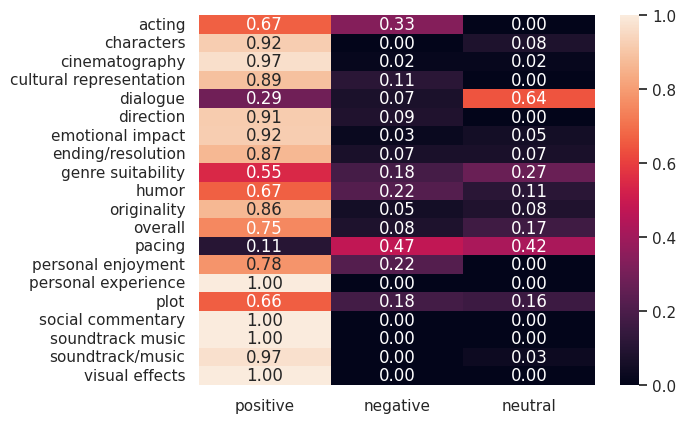

In [15]:
sns.set_theme(style="darkgrid")
sns.heatmap(absa_counts_df, cmap="rocket", annot=True, fmt=".2f")

## 讓模型幫忙標記評論

有一個套件可以輕鬆讓你顯示被標記的文本: https://github.com/tvst/st-annotated-text

它提供一個函數 `annotated_text`，可以把一個字串和一個標記的字串當作參數，然後把標記的字串顯示成不同的顏色。

```python
{
    "review": [
        "The ",
        ("CGI was amazing", "Visual Effects", "#afa"),
        " but I think that the ",
        ("acting was terrible", "Acting", "#faa"),
        " and I ",
        (" do not have an opinion on the plot", "Plot", "#bebebe"),
        ".",
    ]
}

```

`get_annotated_text` 請模型把評論中的 aspect 標記出來並使用 `annotated_text` 所期待的格式輸出資料。

In [20]:
r = "spent some of the movie worried it was gonna be too hard to pin down, or aiming at too many topics at once, barraging the viewer with inventiveness at the cost of coherence. what a fool I am. Miyazaki knows exactly what he's doing, and the ending is so wonderful and shattering."
annotated = get_annotated_absa(
    client=openai.Client(), 
    text=r, 
    aspects=aspects.MOVIE_ASPECTS,
    model_name=OpenAIModel.GPT4)
pprint(annotated)

['spent some of the movie worried it was gonna be ',
 (' too hard to pin down, or aiming at too many topics at once, barraging the '
  'viewer with inventiveness at the cost of coherence',
  'Pacing',
  '#faa'),
 ". what a fool I am. Miyazaki knows exactly what he's doing, and the ending "
 'is so ',
 ('wonderful', 'Ending/Resolution', '#afa'),
 ' and ',
 ('shattering', 'Emotional Impact', '#afa'),
 '.']


## 最後作文字雲～

先算每個字的頻率並拿掉停用字

In [72]:
en_stopwords = stopwords.words("english")
word_counts = create_word_count([r.review for r in reviews], en_stopwords)
word_counts.most_common(10)

[('film', 213),
 ('miyazaki', 184),
 ('like', 135),
 ('de', 126),
 ('one', 109),
 ('world', 102),
 ('boy', 99),
 ('que', 94),
 ('it’s', 84),
 ('movie', 72)]

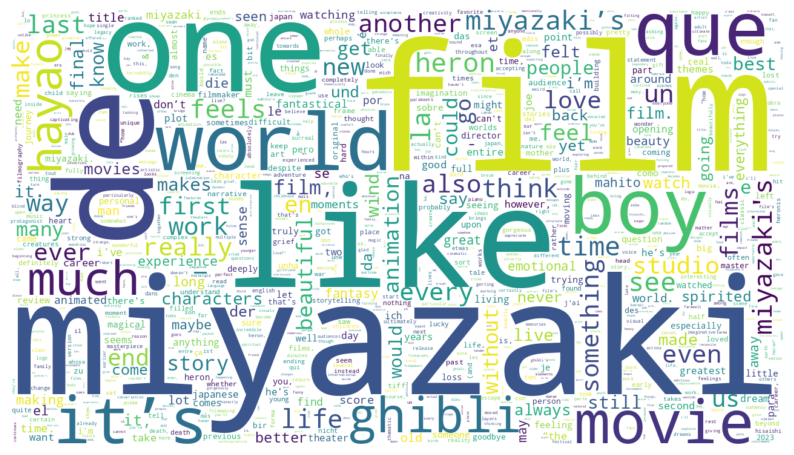

In [22]:
create_wordcloud(word_counts)

# PTT

## 抓資料

In [32]:
post = get_ptt_post("https://www.ptt.cc/bbs/Stock/M.1702042525.A.05E.html")
post

PTTPost(metadata=PTTMetadata(author='Vistorieaz (Euphorzolam)', board='Stock', title='[請益] 該如何制定臺股長期投資組合', published_date=datetime.datetime(2023, 12, 8, 21, 35, 20), author_ip='※ 發信站: 批踢踢實業坊(ptt.cc), 來自: 150.116.236.102 (臺灣)', url='https://www.ptt.cc/bbs/Stock/M.1702042525.A.05E.html'), comments=[PTTComment(username='johnyang', tag='推', content=' 你沒有提到投資目標 要拿市場報酬還是超額報酬 還', published_date=datetime.datetime(1900, 12, 8, 21, 38)), PTTComment(username='johnyang', tag='→', content=' 有你願意為了安心感付出多少成本', published_date=datetime.datetime(1900, 12, 8, 21, 38)), PTTComment(username='johnyang', tag='→', content=' 奉勸一句 配置盡可能單純 未來才好調整', published_date=datetime.datetime(1900, 12, 8, 21, 39)), PTTComment(username='sw9294', tag='推', content=' 市值型ETF+高股息ETF', published_date=datetime.datetime(1900, 12, 8, 21, 41)), PTTComment(username='saber50116', tag='→', content=' 我是1個月15000投到00692，它既是類大盤加上高股息', published_date=datetime.datetime(1900, 12, 8, 21, 42)), PTTComment(username='saber50116', tag='→', content='

## ABSA

In [46]:
absa = get_absa(
    client=client,
    texts=[c.content for c in post.comments],
    base_prompt=GET_ABSA_FINANCE_PROMPT,
    main_body=post.main_body,
    model_name=OpenAIModel.GPT3_5
)
pprint(absa)

2023-12-09 10:58:42.105 | INFO     | scrape.absa.absa:get_absa:44 - Chunked into 4 chunks


  0%|          | 0/4 [00:00<?, ?it/s]

[('text_1', {'Costs': 'neutral', 'Investment Goal': 'neutral'}),
 ('text_2', {'Investment Goal': 'neutral'}),
 ('text_3', {'Asset Allocation': 'positive'}),
 ('text_4', {'Investment Portfolio': 'positive'}),
 ('text_5', {'Investment Strategy': 'positive'}),
 ('text_6', {'Investment Strategy': 'positive'}),
 ('text_7', {'Investment Advice': 'neutral'}),
 ('text_8', {'Investment Advice': 'neutral'}),
 ('text_9', {'Investment Strategy': 'neutral'}),
 ('text_10', {'Asset Allocation': 'negative'}),
 ('text_11', {'Investment Strategy': 'neutral'}),
 ('text_12', {'Investment Advice': 'neutral'}),
 ('text_13', {'Investment Strategy': 'neutral'}),
 ('text_14', {'Investment Portfolio': 'positive'}),
 ('text_15', {'Asset Allocation': 'positive', 'Risk Tolerance': 'positive'}),
 ('text_16', {'Investment Strategy': 'negative'}),
 ('text_17', {'Market Performance': 'neutral'}),
 ('text_18',
  {'Investment Strategy': 'positive', 'Market Performance': 'positive'}),
 ('text_19', {'Investment Advice': '

## 生成摘要

In [55]:
summary_input = [
    f"POSTER: {post.metadata.author}",
    f"MAIN_BODY:\n{post.main_body}",
    f"COMMENTS:",
    "\n".join(f"{c.username}: {c.content}" for c in post.comments),
]
summary_input = "\n".join(summary_input)
print(summary_input)

POSTER: Vistorieaz (Euphorzolam)
MAIN_BODY:
各位股板的先進大家安安
本身不是金融背景，雖然做了點功課但又覺得無法解答我內心的疑惑
因此想請教各位先進下列四個問題大家各自有什麼看法呢


最近開始工作想定期定額投入一筆錢(約5,000~15,000NTD/月)到股市
持有時間也會以長期為主，希望能維持至少10~20年不會特別動到

本次考慮的標的有以下四種
1.市值型ETF
2.股利型ETF
3.金融/代工股
4.券商主力基金


Ｑ1:市值型ETF的隱憂
若把臺股拉長來看，在疫情爆發之後台股才有明顯的漲幅
若在拉鋸不定，多頭不明確的時期
如回到疫情前，臺股始終在7000~10000點左右遊走
當時的股市圈是否會如今日一樣吹捧市值型ETF呢

況且市值型ETF中臺積電的比重往往佔比超過五成
假設臺積電未來的營運不如預期，市值型ETF是否也會因此受到打擊
還是會因為透過調整比重來規避掉某些公司市值降低對基金造成的衝擊呢



Ｑ2:市值型ETF VS 主動型基金
先前看過股板有人比較十年殖利率，結論是除了券商主力基金外
大部分的主動型基金很難打贏大盤
不過券商的主力基金(統一黑馬、野村基金)這些券商的主力基金往往超越大盤
雖然持有成本與風險比起市值型ETF高許多，但殖利率卻也大勝被動型ETF
若以被動市值型ETF為主，主動型基金為輔，這種配置常見嗎



Ｑ3：股利型ETF VS金融/代工股
家人比起金融股更喜歡代工股，就現金殖利率來看某些代工股確實高一些
但股價波動也相對大
若則金融股，雖然股價波動小，但就填及機率與天數來看卻又不如0056
若想要領現金股利重新再投入，又想確保填息機率與天數
是不是選擇股利型ETF是唯一解呢
若趁除權息時買入股票，金融股是否又會比股利型ETF在價格上更具優勢呢



Ｑ4：該如何建立投資組合
因為長期投資的緣故還是希望主要以穩健為主
主體以市值型ETF佔比最大45%再加上輔助的主動型基金20%
最後是股利型ETF/金融代工股35%，這樣的配置是否合理呢

還是說定期定額本身每次投入金額不大，如此細分反而增加了購入成本呢

如果是大家，會如何利用定期定額來規劃自己的投資組合呢
COMMENTS:
johnyang:  你沒有提到投資目標 要拿市場報酬還是超額報酬 還
johnyang:  有你

In [58]:
comments = [f"{c.username}: {c.content}" for c in post.comments]
main_body = f"Poster: {post.metadata.author}\n{post.main_body}"
summary = get_summary(client, texts=comments, main_body=main_body, base_prompt=FINANCE_SUMMARY_PROMPT, model_name=OpenAIModel.GPT4)
print(summary)

## 摘要
台灣的股票論壇上有許多投資者分享他們對於建立一個長期投資組合的看法和建議。投稿者表達了對市值型ETF、股利型ETF、金融/代工股等投資標的的考量和疑慮。其他使用者則回應自己的策略，提到各種基金和ETF的組合，並提供了如定期定額投資和選擇公認的成功股票組合等建議。文章中也出現關於多元化和風險管理的討論，例如主動型基金與市值型ETF之間的比較、股利型ETF與個別金融股或代工股的選擇，以及如何為長期投資配置資產。

## 適合閱讀的人
- **新手投資者**：想要了解各種投資策略並尋求建立長期投資組合的建議。
- **有興趣了解台股市場**：人們詳細討論了台灣股市特有的一些標的，如特定ETF和基金。
- **定期定額投資者**：文章中包含關於如何以定期投資方式布局台股的討論。
- **追求高股息收益的投資者**：對於追求股息回報的人來說，會發現關於股息型ETF和高股息股票的討論。

## 不適合閱讀的人
- **尋求非台股或國際股市投資策略的投資者**：討論主要集中在台灣股市，對其他市場可能不相關。
- **專業投資者或有豐富經驗的交易者**：文章的對象更偏向投資新手，專業交易者可能不會從中獲得太多新見解。
- **純粹尋求短期交易策略的人**：討論集中在長期投資，對於那些希望從短期市場波動中獲利的人可能不太適合。


## 儲存

我們用 `pickle` 存資料，因為它可以儲存 Python 的物件。它將物件轉換成二進位檔案，所以可以保留物件的結構。

In [61]:
with ptt_path.open("xb") as f:
    pickle.dump(post, f)
with ptt_summary_path.open("x") as f:
    print(summary, file=f)
with ptt_absa_path.open("x") as f:
    json.dump(absa, f, ensure_ascii=False, indent=4)

## 載入資料

In [4]:
with ptt_path.open("rb") as f:
    post: PTTPost = pickle.load(f)
with ptt_summary_path.open() as f:
    summary = f.read()
with ptt_absa_path.open() as f:
    absa = json.load(f)

## 建立 PTT dataframe 並增加資料

In [5]:
comments_df = pd.DataFrame([asdict(c) for c in post.comments])
comments_df['published_date'] = comments_df['published_date'].dt.strftime('%m-%d %H:%M:%S')
comments_df

,username,tag,content,published_date
0,johnyang,推,你沒有提到投資目標 要拿市場報酬還是超額報酬 還,12-08 21:38:00
1,johnyang,→,有你願意為了安心感付出多少成本,12-08 21:38:00
2,johnyang,→,奉勸一句 配置盡可能單純 未來才好調整,12-08 21:39:00
3,sw9294,推,市值型ETF+高股息ETF,12-08 21:41:00
4,saber50116,→,我是1個月15000投到00692，它既是類大盤加上高股息,12-08 21:42:00
...,...,...,...,...
80,riahserf,推,之前研究過 統一基金是真的猛@@,12-09 12:25:00
81,Radiomir,推,"00713+招牌主動型基金,大跌時記得把00713轉成00631",12-09 13:38:00
82,johnyang,推,哆拉王已經說明很清楚了 希望原po好好衡量,12-09 14:30:00
83,gastboy,推,台積配兆豐跟一點台塑,12-09 15:00:00


## ABSA 加到 PTT dataframe

In [6]:
absa_df = create_absa_df(absa)
absa_df

,positive,negative,neutral
user_idx,,,
0,,,"investment goal, costs"
1,,,investment goal
2,asset allocation,,
3,investment portfolio,,
4,investment strategy,,
...,...,...,...
80,company announcements,,
81,,,market performance
82,,,market performance


In [7]:
ptt_df = pd.merge(comments_df, absa_df, left_index=True, right_index=True, how="outer")
ptt_df

,username,tag,content,published_date,positive,negative,neutral
0,johnyang,推,你沒有提到投資目標 要拿市場報酬還是超額報酬 還,12-08 21:38:00,,,"investment goal, costs"
1,johnyang,→,有你願意為了安心感付出多少成本,12-08 21:38:00,,,investment goal
2,johnyang,→,奉勸一句 配置盡可能單純 未來才好調整,12-08 21:39:00,asset allocation,,
3,sw9294,推,市值型ETF+高股息ETF,12-08 21:41:00,investment portfolio,,
4,saber50116,→,我是1個月15000投到00692，它既是類大盤加上高股息,12-08 21:42:00,investment strategy,,
...,...,...,...,...,...,...,...
80,riahserf,推,之前研究過 統一基金是真的猛@@,12-09 12:25:00,company announcements,,
81,Radiomir,推,"00713+招牌主動型基金,大跌時記得把00713轉成00631",12-09 13:38:00,,,market performance
82,johnyang,推,哆拉王已經說明很清楚了 希望原po好好衡量,12-09 14:30:00,,,market performance
83,gastboy,推,台積配兆豐跟一點台塑,12-09 15:00:00,,,company announcements


## 算ABSA各個面向的情感分數

In [8]:
absa

[['text_1', {'Investment Goal': 'neutral', 'Costs': 'neutral'}],
 ['text_2', {'Investment Goal': 'neutral'}],
 ['text_3', {'Asset Allocation': 'positive'}],
 ['text_4', {'Investment Portfolio': 'positive'}],
 ['text_5', {'Investment Strategy': 'positive'}],
 ['text_6', {'Investment Strategy': 'positive'}],
 ['text_7', {'Investment Advice': 'neutral'}],
 ['text_8', {'Investment Advice': 'neutral'}],
 ['text_9', {'Investment Strategy': 'neutral'}],
 ['text_10', {'Asset Allocation': 'negative'}],
 ['text_11', {'Investment Strategy': 'neutral'}],
 ['text_12', {'Investment Advice': 'neutral'}],
 ['text_13', {'Investment Strategy': 'neutral'}],
 ['text_14', {'Investment Portfolio': 'positive'}],
 ['text_15', {'Risk Tolerance': 'positive', 'Asset Allocation': 'positive'}],
 ['text_16', {'Investment Strategy': 'negative'}],
 ['text_17', {'Market Performance': 'neutral'}],
 ['text_18',
  {'Market Performance': 'positive', 'Investment Strategy': 'positive'}],
 ['text_19', {'Investment Advice': '

In [9]:
absa_counts = count_absa(absa)
print(absa_counts.positive.most_common(10))
print(absa_counts.negative.most_common(10))
print(absa_counts.neutral.most_common(10))

[('investment strategy', 7), ('market performance', 6), ('dividends and buybacks', 5), ('investment recommendation', 4), ('asset allocation', 3), ('investment portfolio', 2), ('risk tolerance', 1), ('investment advice', 1), ('company performance', 1), ('macroeconomic indicators', 1)]
[('market performance', 7), ('investment strategy', 2), ('investment recommendation', 2), ('dividends and buybacks', 2), ('asset allocation', 1), ('risk tolerance', 1), ('macroeconomic indicators', 1), ('earnings and revenue', 1), ('competitor analysis', 1)]
[('market performance', 10), ('investment strategy', 9), ('investment recommendation', 5), ('investment advice', 4), ('investment goal', 2), ('debt and financial stability', 2), ('earnings and revenue', 2), ('dividends and buybacks', 2), ('costs', 1), ('company performance', 1)]


In [10]:
absa_counts_df = create_absa_counts_df(absa_counts)
absa_counts_df

,positive,negative,neutral
asset allocation,0.750000,0.250000,0.000000
company announcements,0.500000,0.000000,0.500000
company performance,0.500000,0.000000,0.500000
competitor analysis,0.000000,0.500000,0.500000
costs,0.000000,0.000000,1.000000
crisis management,0.000000,0.000000,1.000000
debt and financial stability,0.000000,0.000000,1.000000
dividends and buybacks,0.555556,0.222222,0.222222
earnings and revenue,0.000000,0.333333,0.666667
financial stability,0.000000,0.000000,1.000000


<Axes: >

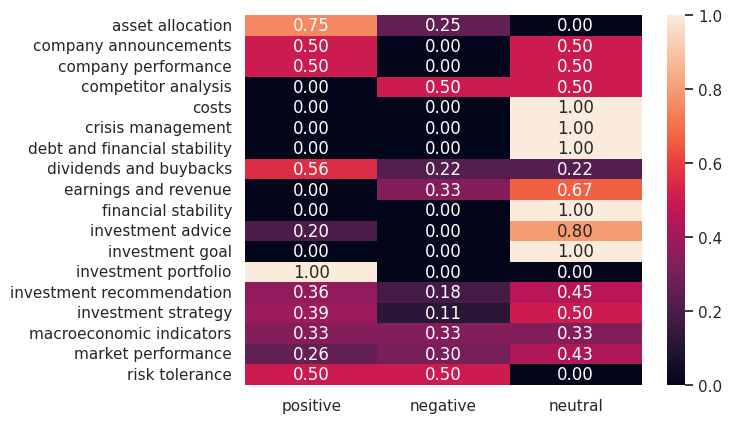

In [11]:
sns.set_theme(style="darkgrid")
sns.heatmap(absa_counts_df, cmap="rocket", annot=True, fmt=".2f")

## 文字雲

需要先斷詞

In [21]:
segmented = [
    re.sub(r"\s+", " ", " ".join(jieba.lcut(c.content)).strip()) for c in post.comments
]
pprint(segmented[0])

'你 沒有 提到 投資 目標 要 拿 市場 報酬 還是 超額 報酬 還'


In [22]:
with open('../data/trad-stopwords.txt') as f:
    zh_stopwords = f.read().splitlines()
zh_stopwords[:10]

['、', '。', '〈', '〉', '《', '》', '一', '一個', '一些', '一何']

In [23]:
word_counts = create_word_count(segmented, zh_stopwords)
word_counts.most_common(10)

[('etf', 11),
 ('高', 8),
 ('正', 8),
 ('2', 8),
 ('正二', 8),
 ('型', 7),
 ('買', 7),
 ('報酬', 6),
 ('市值', 6),
 ('+', 6)]

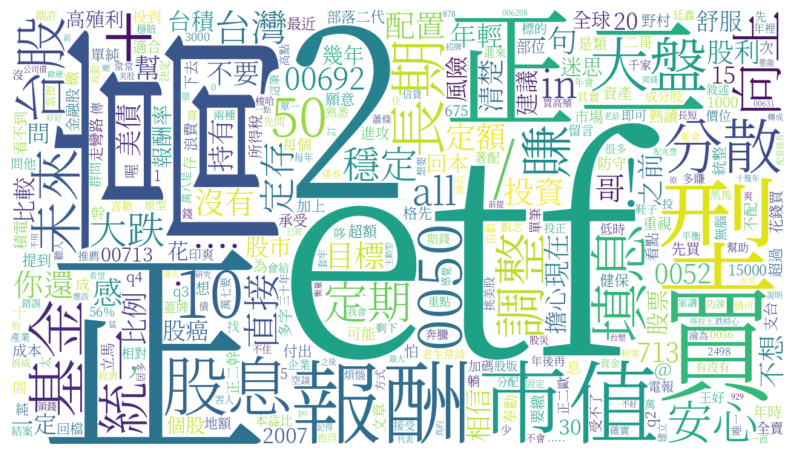

In [25]:
create_wordcloud(word_counts, font_path="../data/fonts/SourceHanSerifK-Light.otf")